# Convolutional Layer

In this notebook, we visualize four filtered outputs (a.k.a. activation maps) of a convolutional layer. 

In this example, *we* are defining four filters that are applied to an input image by initializing the **weights** of a convolutional layer, but a trained CNN will learn the values of these weights.

### Import the image

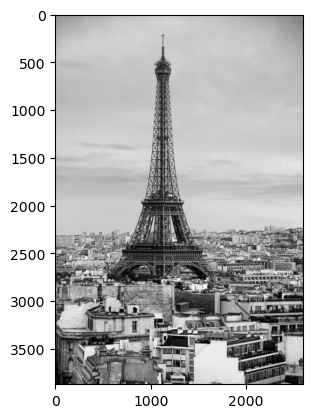

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img_path = '../app_images/image_1.jpg'

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
# plt.axis("off")
plt.show()

### Define and visualize the filters

In [2]:
import numpy as np

"""
CNN Convolution Filter: Vertical Edge Detection Kernel

This 4x4 filter is designed to detect vertical edges in images by comparing 
left and right pixel intensities. It acts as a fundamental building block for 
understanding how convolutional neural networks process visual information.

Filter Structure:
    ┌─────┬─────┬─────┬─────┐
    │ -1  │ -1  │  1  │  1  │
    ├─────┼─────┼─────┼─────┤
    │ -1  │ -1  │  1  │  1  │
    ├─────┼─────┼─────┼─────┤
    │ -1  │ -1  │  1  │  1  │
    ├─────┼─────┼─────┼─────┤
    │ -1  │ -1  │  1  │  1  │
    └─────┴─────┴─────┴─────┘

How it works:
- Left half (-1): Suppresses/detects dark regions on the left side
- Right half (+1): Enhances/detects bright regions on the right side
- Result: Strong response to vertical edges where brightness changes from left to right

Applications:
- Edge detection in computer vision
- Feature extraction in CNNs
- Understanding convolutional filter behavior
- Teaching fundamental CNN concepts

The filter responds strongly to:

- **Vertical edges** where brightness transitions from dark (left) to light (right)
- **Boundaries** between objects in images
- **Structural features** that help CNNs learn visual patterns

This is a fundamental concept in computer vision - CNNs use similar filters in their early 
layers to detect basic visual features like edges, corners, and textures before learning 
more complex patterns in deeper layers.

"""
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

print('Filter shape: ', filter_vals.shape)


Filter shape:  (4, 4)


In [3]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3

# Stack them together in a (4, 4, 4) array
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)

Filter 1: 
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]


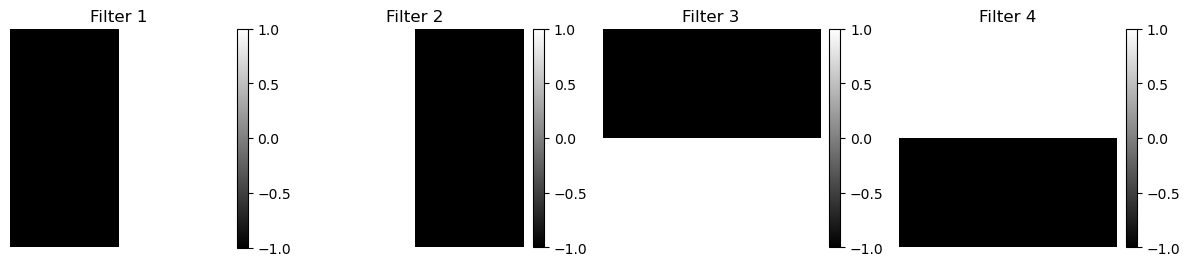

In [4]:
# visualize all four filters
from helpers import visualize_filters

visualize_filters(filters)

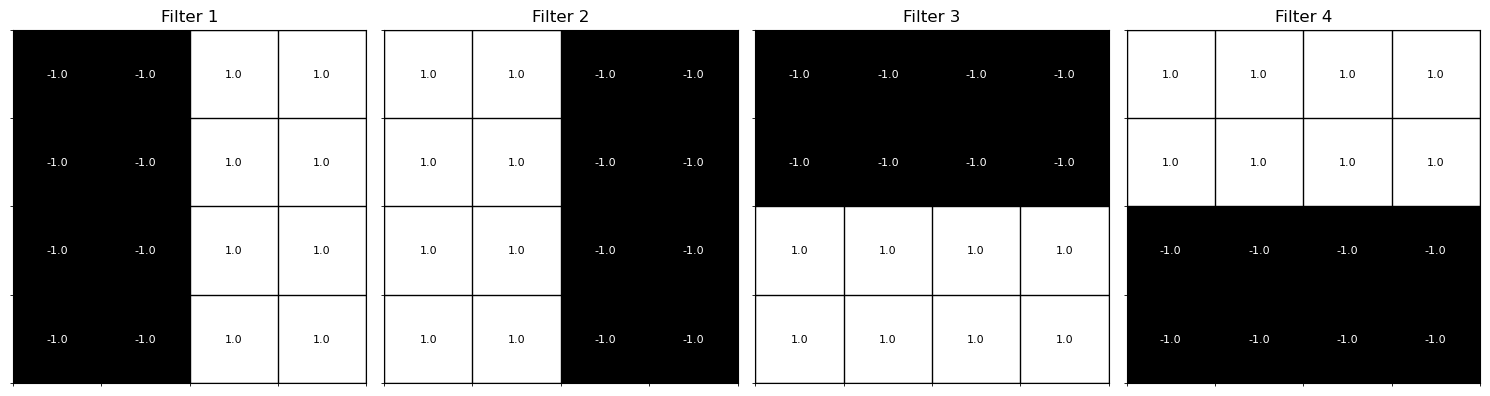

In [5]:
import matplotlib.pyplot as plt

def vis_filters(filters):
    """
    Visualize the given filters in a single row with proper spacing.
    
    Args:
        filters: numpy array of shape (num_filters, height, width)
    """
    num_filters = len(filters)
    
    # Create a figure with a single row of subplots
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 4))
    
    # If there's only one filter, axes won't be an array
    if num_filters == 1:
        axes = [axes]
    
    # Plot each filter
    for i, ax in enumerate(axes):
        # Get the filter values
        f = filters[i]
        
        # Normalize the filter values to [0, 1] for visualization
        f_min, f_max = np.min(f), np.max(f)
        f_normalized = (f - f_min) / (f_max - f_min) if f_max > f_min else f
        
        # Display the filter
        im = ax.imshow(f_normalized, cmap='gray', vmin=0, vmax=1)
        
        # Add value annotations with white/black text based on background
        for (j, k), val in np.ndenumerate(f):
            # Use white text for dark backgrounds, black for light
            text_color = 'white' if f_normalized[j, k] < 0.5 else 'black'
            ax.text(k, j, f'{val:.1f}', 
                   ha='center', va='center', 
                   color=text_color,
                   fontsize=8)  # Smaller font size
    
        # Add grid lines
        ax.set_xticks(np.arange(-0.5, f.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, f.shape[0], 1), minor=True)
        ax.grid(which="minor", color='black', linestyle='-', linewidth=1)
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Filter {i+1}')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# filter_1 = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])
# Example usage:
vis_filters(filters)

#### Define a convolutional layer 

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll start by defining a __Convolutional layer__.

Initialize a single convolutional layer so that it contains all your created filters:

In [6]:
import torch

"""
Extract filter/kernel dimensions for convolution visualization.

These lines extract the spatial dimensions (height and width) from the filters array.
The shape[-1] gets the last dimension (width), and we assume square filters 
(common in CNNs) so width equals height.

Variables:
    k_height: Kernel height dimension (e.g., 3, 4, or 5 for common filter sizes)
    k_width: Kernel width dimension (same as height for square filters)
"""
k_height = filters.shape[-1]
k_width = k_height

"""
    In convolutional layers:
    - 'Filters' and 'kernels' refer to the same thing - the small weight matrices that slide across the input
    - Each filter/kernel produces one output feature map/channel
    - out_channels=4 means the layer will use 4 distinct filters/kernels
    - Each filter has dimensions: (kernel_size x kernel_size x in_channels)

    Filters/kernels don't have to be square - they can be rectangular. 
    However, square filters (like 3x3, 5x5) are most common because:

    1. Symmetry simplifies implementation
    2. Easier to specify (just one dimension like kernel_size=3)
    3. Work well for most image patterns

    But you can use rectangular filters by specifying different height/width:
    nn.Conv2d(..., kernel_size=(3,5))  # 3 rows x 5 columns filter

    ##### Convolutional Layer Setup for CNN Visualization

    Creates a 2D convolutional layer configured to demonstrate how filters transform 
    input images. This setup allows manual filter assignment to visualize specific edge 
    detection patterns.

    Layer Configuration:
        - in_channels=1: Single grayscale input channel
        - out_channels=4: Four output feature maps (one per filter)
        - kernel_size: Square kernel dimensions (height, width)
        - stride=1: Standard convolution stride
        - padding=0: No padding for edge detection visualization
        - bias=False: Skip bias to focus on filter weights only
"""

conv_layer = torch.nn.Conv2d(
    # Number of input channels. This is grayscale, so 1.
    # If the image was a normal RGB image, this would be 3.
    in_channels=1,
    # Number of output feature maps. Let's do 4 like the filters
    # we want to use (remember, each filter results in one 
    # feature map)
    out_channels=4, 
    # Size of the convolutional kernel
    kernel_size=(k_height, k_width), 
    stride=1, 
    padding=0,
    # Let's skip the bias for the moment, so we can easily
    # initialize our layer with the filters we already have
    bias=False,
)


"""
    In real CNNs:
    1. Filter weights are learned during training (via backpropagation)
    2. Initial random weights get adjusted to detect important features

    In this educational example:
    1. We manually set fixed weights to:
    - Demonstrate how filters work
    - Show specific edge-detection patterns
    - Make the visualization predictable

    Why we assign them directly:
    - This is a teaching example, not real training
    - Shows how filters affect the output
    - Lets us study known filter behaviors
    - Normally you'd NEVER hardcode weights like this

    In trained CNNs:
    1. The kernel/filter values ARE the learned weights
    2. After training, each filter's weights represent:
    - The optimal pattern detector for some feature
    - Learned from the training data
    3. Process:
    a) Initialize random weights (kernels start random)
    b) Training adjusts these weights via backpropagation
    c) Final weights become the feature detectors

    Key point: 
    - There's no separate "values" and "weights" 
    - The filter values = the layer's weight parameters
    - Weights are just the numerical values in the kernel matrix

    This is purely for educational demonstration:

    1. Normal Workflow:
    - Weights initialize randomly
    - Model learns optimal weights during training
    - Never manually set weights in practice

    2. This Educational Example:
    - Manually defines filters (edge detectors)
    - Directly assigns them as conv layer weights
    - Purpose is to:
        * Show how specific filters transform input
        * Demonstrate convolution mechanics
        * Visualize known filter behaviors

    Key Difference:
    - Normally: weights = learned parameters
    - Here: weights = hand-picked filters for visualization
"""
weights = (torch
           .from_numpy(filters)  # note: this does not copy the data
           # add the n_channels dimension, so the tensor has the 
           # shape 
           # (n_filters, n_channels, filter_height, filter_width)
           .unsqueeze(dim=1)
           # Make sure we have a FloatTensor (fp32)
           .type(torch.FloatTensor)
          )

# Assign the filters to the weights of the layer
# we use torch.nn.Parameter so the weights
# are recognized as parameters of the model
conv_layer.weight = torch.nn.Parameter(weights)

And now let's see it in action on our input image:

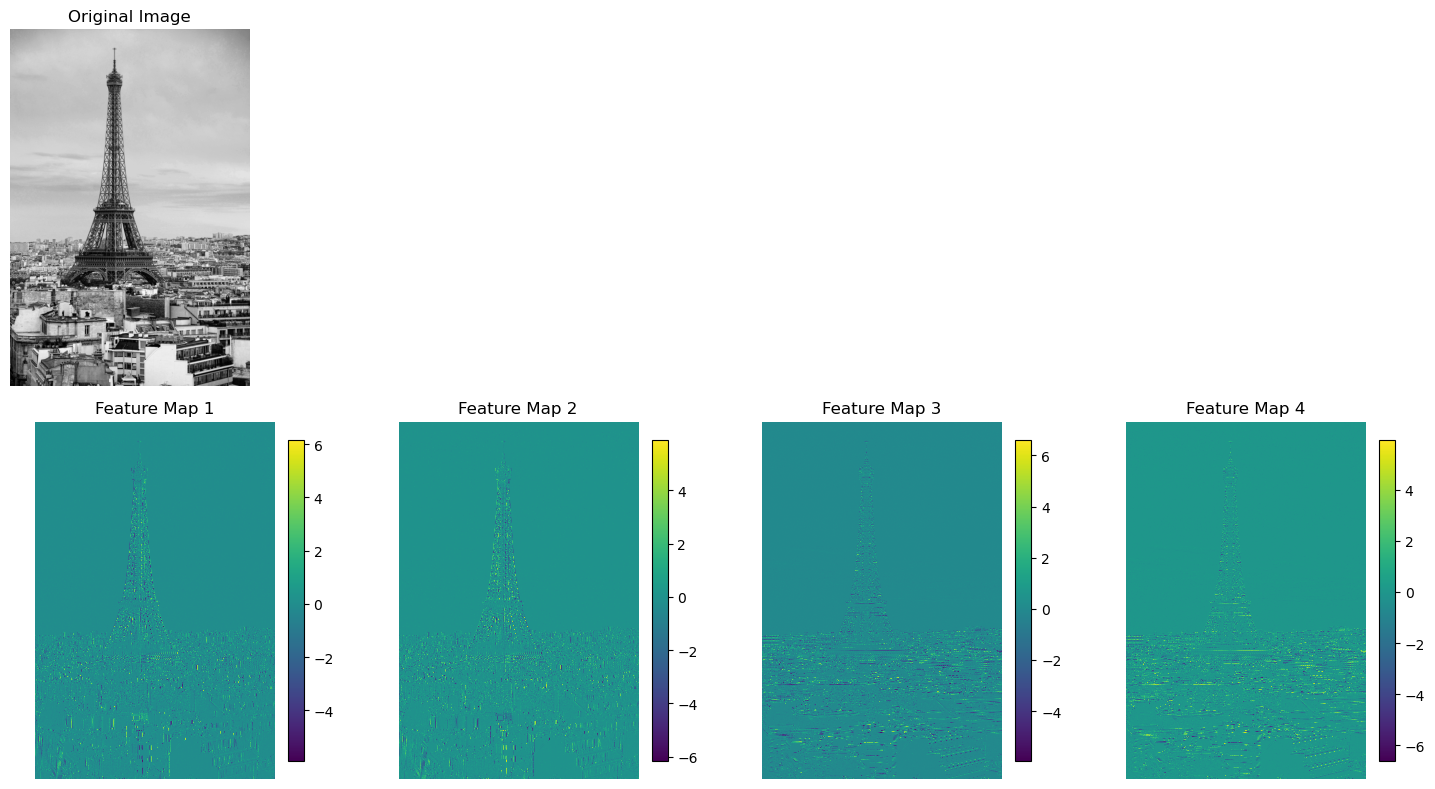

In [7]:
from helpers import show_feature_maps

# convert the image into an input Tensor
# with shape (n_items_in_batch, n_channels, height, width)
x = (
    torch.from_numpy(gray_img)
    # Add one dimension for batch
    .unsqueeze(0)
    # Add dimension for n_channels
    .unsqueeze(1)
)

# Pass the image through the layer
# (this calls the .forward of the layer)
feature_maps = conv_layer(x)

show_feature_maps(gray_img, feature_maps, filters)


---

##### Understanding Feature Maps

Feature maps (also called activation maps) show how strongly different parts of the input image activate each convolutional filter. Here's how to interpret what you're seeing:

### Color Scale Interpretation:
- **Yellow/Bright areas**: High positive activations (strong response to the filter)
- **Dark blue/Purple areas**: Negative activations or no response
- **Teal/Green areas**: Moderate activations

### What Each Feature Map Reveals:

**Feature Map 1**: Shows strong vertical edge detection - you can see bright yellow lines where there are vertical structures in the original image (like building edges, poles, etc.)

**Feature Map 2**: Appears to be detecting different orientations of edges or textures, with more distributed activations across the image

**Feature Map 3**: Shows horizontal edge detection - notice the horizontal patterns that are highlighted, particularly where there are horizontal structures in the buildings

**Feature Map 4**: Seems to be detecting diagonal edges or corner features - areas where different structural elements meet

### Key Insights:

1. **Edge Detection**: These early convolutional layers are primarily acting as edge detectors at different orientations (vertical, horizontal, diagonal)

2. **Spatial Correspondence**: The bright areas in each feature map correspond to locations in the original image where that particular feature (edge type) is present

3. **Filter Specialization**: Each filter has learned to detect different types of features - this is the foundation of how CNNs build hierarchical representations

4. **Feature Hierarchy**: These low-level features (edges) will be combined by deeper layers to detect more complex patterns like shapes, objects, etc.

This is exactly what we expect to see in the first convolutional layer of a CNN - basic edge and texture detectors that form the building blocks for more complex feature recognition in deeper layers!

---

#### A PyTorch model: `__init__` and `forward`
Let's now see how we can use a convolutional layer (or any other layer) in a model in PyTorch.

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the forward behavior of a network that applyies those initialized layers to an input (`x`) in the function `forward` (named after "forward pass", as opposed to backpropagation). In PyTorch we convert all inputs into the Tensor datatype, which is similar to a list data type in Python. 

Below, I define the structure of a class called `Net` that has a convolutional layer similar to what we used before:

In [8]:
class Net(torch.nn.Module):
    """
    A simple Convolutional Neural Network for visualizing feature maps.
    
    This network consists of a single convolutional layer followed by ReLU activation.
    The convolutional filters are manually initialized rather than learned, making it
    useful for educational purposes to understand how different filters respond to input images.
    
    Attributes:
        conv_layer (torch.nn.Conv2d): Convolutional layer with manually set weights
        relu (torch.nn.ReLU): ReLU activation function
    """
    
    def __init__(self, filters):
        """
        Initialize the network with predefined convolutional filters.
        
        Args:
            filters (numpy.ndarray): Array of convolutional filters with shape
                (num_filters, height, width). These filters will be used as the
                weights for the convolutional layer instead of random initialization.
        
        Note:
            The filters are manually set rather than learned through training,
            which allows us to visualize how specific filter patterns respond
            to input images.
        """
        super(Net, self).__init__()
        
        # Extract filter dimensions (assuming square filters)
        k_height = filters.shape[-1]
        k_width = k_height
        
        # Define the convolutional layer
        # - in_channels=1: expects grayscale input images
        # - out_channels=4: produces 4 feature maps (one per filter)
        # - kernel_size: determined by filter dimensions
        # - stride=1: move filter one pixel at a time
        # - padding=0: no padding around input
        # - bias=False: no bias term (only using filter weights)
        self.conv_layer = torch.nn.Conv2d(
            in_channels=1,
            out_channels=4, 
            kernel_size=(k_height, k_width), 
            stride=1, 
            padding=0,
            bias=False
        )
        
        # Add ReLU activation function
        # This introduces non-linearity and sets negative values to zero
        self.relu = torch.nn.ReLU()
        
        # Manual weight initialization (not typical in real CNNs)
        # Convert numpy filters to PyTorch tensor format:
        # - Add channel dimension with unsqueeze(dim=1) for grayscale input
        # - Convert to FloatTensor for compatibility
        weights = (torch
                   .from_numpy(filters)
                   .unsqueeze(dim=1)
                   .type(torch.FloatTensor)
                  )
        
        # Set the convolutional layer weights to our predefined filters
        # This replaces the random initialization that would normally occur
        self.conv_layer.weight = torch.nn.Parameter(weights)
        

    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 1, height, width)
                representing grayscale images
        
        Returns:
            torch.Tensor: Output feature maps with shape (batch_size, 4, out_height, out_width)
                where out_height and out_width depend on input size and filter size
        
        Process:
            1. Apply convolutional layer (filters detect features)
            2. Apply ReLU activation (remove negative values)
        """
        # Apply convolutional layer - this convolves each filter with the input
        # producing one feature map per filter
        x = self.conv_layer(x)
        
        # Apply ReLU activation - sets all negative values to zero
        # This helps the network learn non-linear patterns
        x = self.relu(x)
        
        return x

# Instantiate the model with our predefined filters
model = Net(filters)

# print out the layer in the network
# the output of the following print is NOT necessarily the structure
# of the network. Indeed, things will be printed here in the order
# that they are defined in the __init__, and NOT in the order they
# are used in the .forward method. Try to switch the definition of
# self.relu and self.conv_layer in the __init__ (without changing the 
# .forward method) and see what happens to this print
print(model)

Net(
  (conv_layer): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (relu): ReLU()
)


#### ReLU activation
Remember that the activation function called ReLU (Rectified Linear Unit) turns all negative pixel values in 0's (black) while keeping the positive values untouched:

Let's visualize what happens when applying it to our feature maps (compare it with the feature maps we have obtained before):

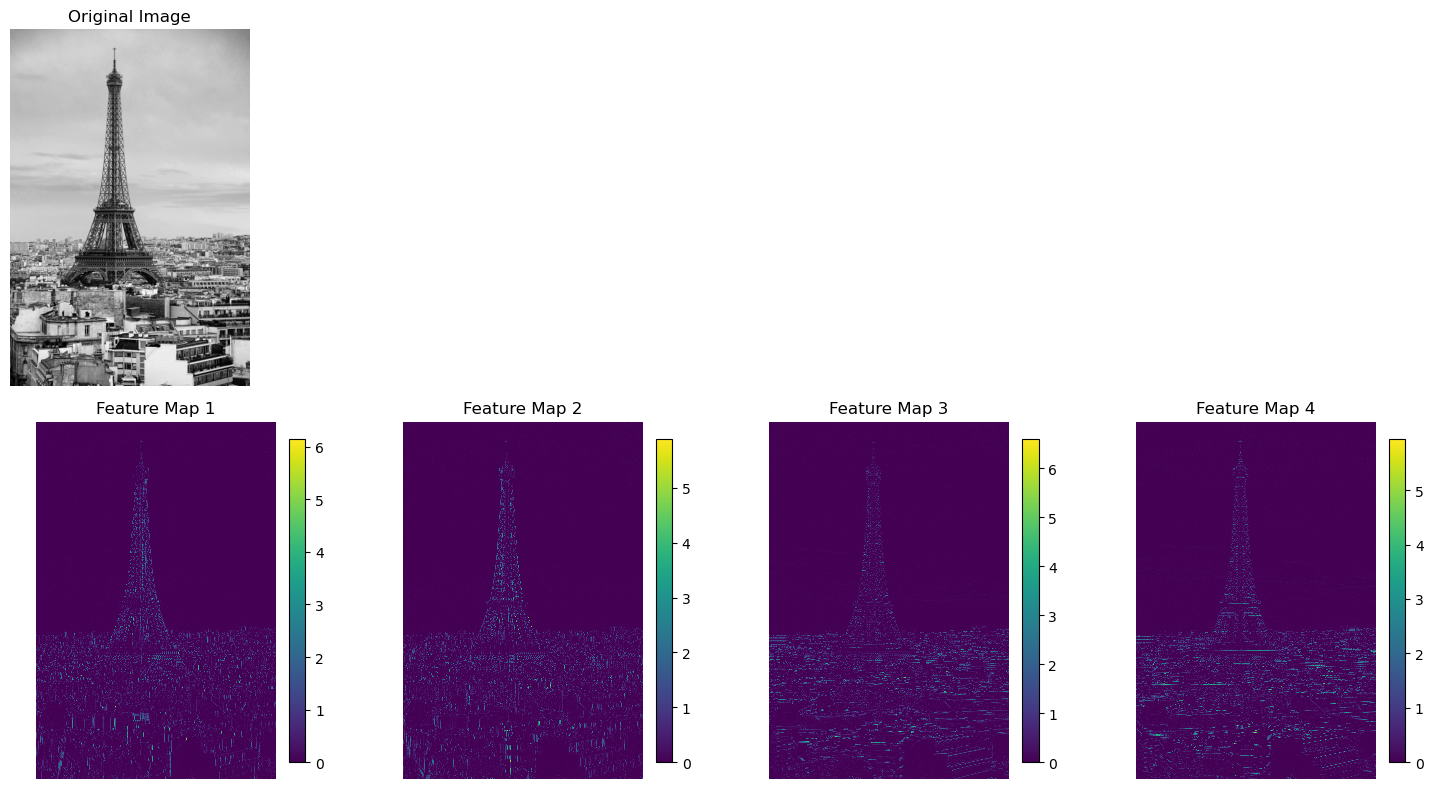

In [9]:
post_act_feature_maps = model(x)

show_feature_maps(gray_img, post_act_feature_maps, filters)

Compare these feature maps with what we obtained from the conv layer without activation. We can immediately see that applying ReLU is equivalent to applying a hard threshold on our feature maps: only strong edges are preserved, everything else becomes 0.

In [10]:
import torch

# define a neural network with a convolutional layer with four filters
# AND a pooling layer of size (2, 2)
class ConvPoolVisualizer(torch.nn.Module):
    """
    A Convolutional Neural Network with Max Pooling for feature map visualization.
    
    This network extends the basic convolutional layer by adding max pooling,
    which reduces spatial dimensions and increases translation invariance.
    The combination demonstrates how pooling affects feature representations.
    
    Architecture:
        1. Convolutional layer (manual filter weights)
        2. ReLU activation
        3. Max pooling (2x2 with stride 2)
    
    Attributes:
        conv_layer (torch.nn.Conv2d): Convolutional layer with predefined filters
        activation (torch.nn.ReLU): ReLU activation function
        max_pool (torch.nn.MaxPool2d): Max pooling layer for spatial downsampling
    """

    def __init__(self, filters):
        """
        Initialize the network with convolutional filters and max pooling.
        
        Args:
            filters (numpy.ndarray): Predefined convolutional filters with shape
                (num_filters, height, width). These replace learned weights to
                demonstrate specific filter responses.
        
        Note:
            The max pooling layer will reduce feature map dimensions by half,
            making the output more computationally efficient and translation-invariant.
        """
        super(ConvPoolVisualizer, self).__init__()  # Fixed: was super(Net, self)

        # Extract filter dimensions (assuming square kernels)
        k_height = filters.shape[-1]
        k_width = k_height

        # Define convolutional layer
        # Same configuration as basic Net but with cleaner parameter specification
        self.conv_layer = torch.nn.Conv2d(
            1, 4, kernel_size=(k_height, k_width), stride=1, padding=0, bias=False
        )

        # ReLU activation function
        # Introduces non-linearity by setting negative activations to zero
        self.activation = torch.nn.ReLU()
        
        # Max pooling layer (2x2 kernel, stride 2)
        # Effects:
        # - Reduces spatial dimensions by half (downsampling)
        # - Increases translation invariance (small shifts don't change output)
        # - Reduces computational load for subsequent layers
        # - Helps prevent overfitting by reducing parameter count
        self.max_pool = torch.nn.MaxPool2d(2, 2)

        # Manual weight initialization with predefined filters
        # Convert numpy array to PyTorch tensor format:
        # - Add input channel dimension for grayscale images
        # - Ensure proper data type (FloatTensor)
        weights = torch.from_numpy(filters).unsqueeze(dim=1).type(torch.FloatTensor)
        self.conv_layer.weight = torch.nn.Parameter(weights)

    def forward(self, x):
        """
        Forward pass through convolution, activation, and pooling.
        
        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 1, height, width)
        
        Returns:
            torch.Tensor: Pooled feature maps with shape (batch_size, 4, out_h, out_w)
                where out_h and out_w are approximately half the input dimensions
        
        Processing Pipeline:
            1. Convolution: Apply 4 filters to detect features
            2. Activation: Apply ReLU to introduce non-linearity
            3. Max Pooling: Downsample by taking maximum in 2x2 regions
        
        Key Differences from Basic Net:
            - Output is spatially smaller due to max pooling
            - Features are more robust to small translations
            - Computational efficiency is improved for deeper layers
        """
        # Step 1: Convolutional feature extraction
        x = self.conv_layer(x)
        
        # Step 2: Non-linear activation
        x = self.activation(x)        
        
        # Step 3: Spatial downsampling via max pooling
        # Takes maximum value in each 2x2 region, reducing spatial size by half
        x = self.max_pool(x)

        return x


# instantiate the model and set the weights
model_max_pool = ConvPoolVisualizer(filters)

# print out the layer in the network
print(model_max_pool)

ConvPoolVisualizer(
  (conv_layer): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (activation): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
